# **SKIN LESION DETECTION ALGORITHM**

In [ ]:
! pip install -q kaggle

%matplotlib inline

import itertools
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns

from glob import glob
from PIL import Image
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from tensorflow.keras.applications.xception import Xception
from tensorflow.compat.v1.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import AveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn import metrics

from google.colab import files

np.random.seed(123)
tf.compat.v1.disable_v2_behavior

<function tensorflow.python.compat.v2_compat.disable_v2_behavior()>

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mickyangelo","key":"7026b1a7de58b70aacf6366363e0d718"}'}

In [ ]:
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.20G/5.20G [02:18<00:00, 40.9MB/s]
100% 5.20G/5.20G [02:18<00:00, 40.5MB/s]


In [ ]:
# # Mounted all files and folders in Google Drive

# from google.colab import drive 
# drive.mount('/content/gdrive')

In [ ]:
# Unzip data in Google Colab

!unzip -q /content/skin-cancer-mnist-ham10000.zip -d dataset

In [ ]:
# # Unzip data in Google Drive

# !unzip -q /content/skin-cancer-mnist-ham10000.zip -d '/content/gdrive/My Drive/ML data'

##EXPLORATORY DATA ANALYSIS

In [ ]:
base_skin_dir = "/content/dataset"
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv')) # load in the data
skin_df.head()

In [ ]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic_nevi',
    'mel': 'melanoma',
    'bkl': 'Benign_keratosis-like_lesions',
    'bcc': 'Basal_cell_carcinoma',
    'akiec': 'Actinic_keratoses',
    'vasc': 'Vascular_lesions',
    'df': 'Dermatofibroma'
}

lesion_danger = {
    'nv': 0, # 0 for benign
    'mel': 1, # 1 for malignant
    'bkl': 0,
    'bcc': 1,
    'akiec': 1,
    'vasc': 0,
    'df': 0
}

In [ ]:
skin_df["path"] = skin_df["image_id"].map(imageid_path_dict.get) # map image_id to the path of that image
skin_df["path"] = skin_df["image_id"].map(imageid_path_dict.get) # map image_id to the path of that image
skin_df["cell_type"] = skin_df["dx"].map(lesion_type_dict.get) # map dx to type of lesion
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

skin_df.head()

In [ ]:
skin_df.describe(exclude=[np.number])

In [ ]:
skin_df["Malignant"] = skin_df["dx"].map(lesion_danger.get)

skin_df.head()

In [ ]:
skin_df["Malignant"].value_counts().plot(kind="bar", title="Benign vs Malignant")

#### **OBSERVATION:** Most cases represented are non-cancerous ie; BENIGN while a very small part of the data belongs to the cancerous ie; MALIGNANT class.

In [ ]:
fig, ax1 = plt.subplots(1,1,figsize=(10,5))
skin_df["cell_type"].value_counts().plot(kind="bar", ax=ax1, title="Counts for each type of Lesions") # plot a graph counting the number of each cell type

#### **OBSERVATIONS:** The dataset is biased towards the Melanocytic_nevi cell type. Melanocytic nevi are common and are generally harmless (benign) and this is expected since most data represented are bening too.

<Axes: title={'center': 'Location of Lesions'}>

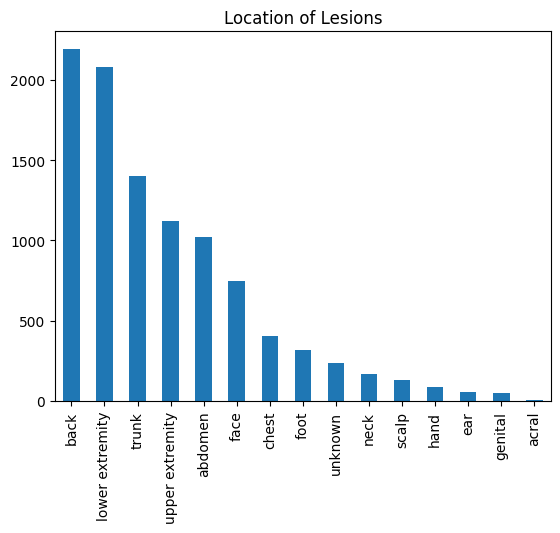

In [ ]:
# let's see where lesions are mostly located

skin_df["localization"].value_counts().plot(kind='bar', title="Location of Lesions")

#### **OBSERVATION:** Most skin lesions occur at the back and the lower extremity regions of the body.

<Axes: title={'center': 'Treatment received'}>

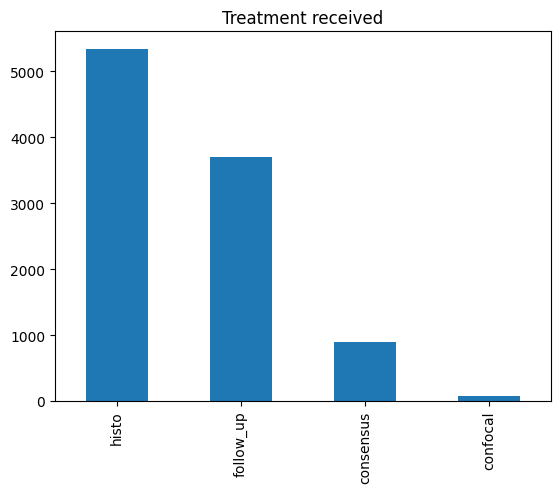

In [ ]:
skin_df["dx_type"].value_counts().plot(kind='bar', title="Treatment received")

#### **OBSERVATIONS:**
Each dx_type has its own description:

histo: "Histopathologic diagnoses of excised lesions have been performed by specialized dermatopathologists."

"We accepted this as evidence of biologic benignity if nevi monitored by digital dermatoscopy did not show any changes during three follow-up visits or 1.5 years." Because dermatologists typically do not monitor dermatofibromas, seborrheic keratoses, or vascular lesions, only nevi were labeled with this type of ground-truth."

"We provide an expert consensus rating of authors PT and HK for typical benign cases without histopathology or follow-up." Only when both authors independently delivered the same clear benign diagnosis did we use the consensus designation. Lesions with this sort of ground-truth were often documented for educational purposes and did not require additional follow-up or biopsy.

"Reflectance confocal microscopy is an in-vivo imaging technique with a resolution at the near-cellular level, and some facial benign keratoses were verified by this method."

<Axes: >

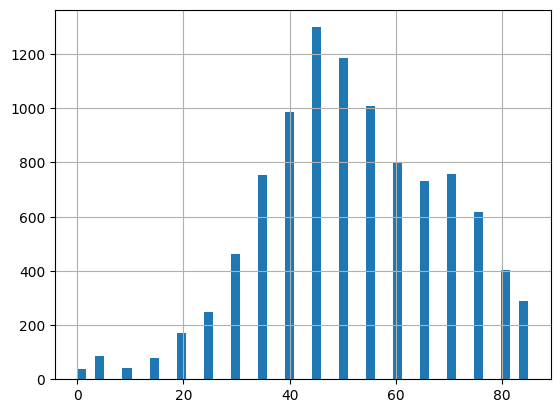

In [ ]:
# PATIENT CHARACTERISTICS & DEMOGRAPHY

skin_df["age"].hist(bins=50)

#### **OBSERVATION:** Most skin lesions affects people between the age range of 40 - 60.

<Axes: >

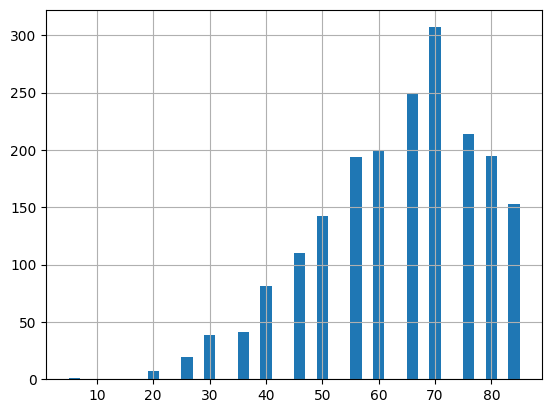

In [ ]:
skin_df[skin_df["Malignant"] == 1]["age"].hist(bins=40)

#### **OBSERVATION:** The age group 65-75 experience the malignant class of skin lesions more.

<Axes: title={'center': 'Male vs Female'}>

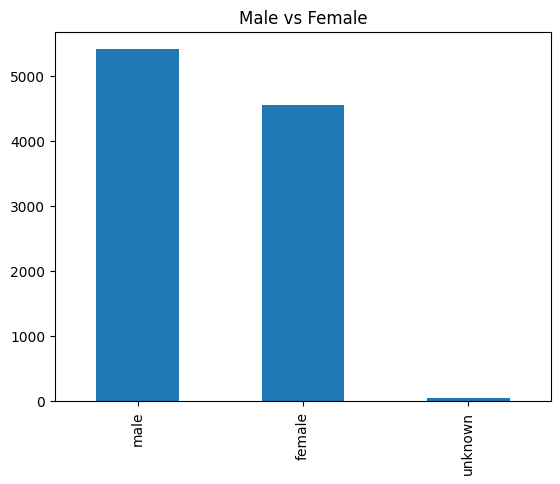

In [ ]:
skin_df["sex"].value_counts().plot(kind="bar", title="Male vs Female")

#### **OBSERVATION:** Our data is hugely represented by the male gender but the difference between both male and female genders is not too high.

<Axes: title={'center': 'Male vs Female. Malignant Cases'}>

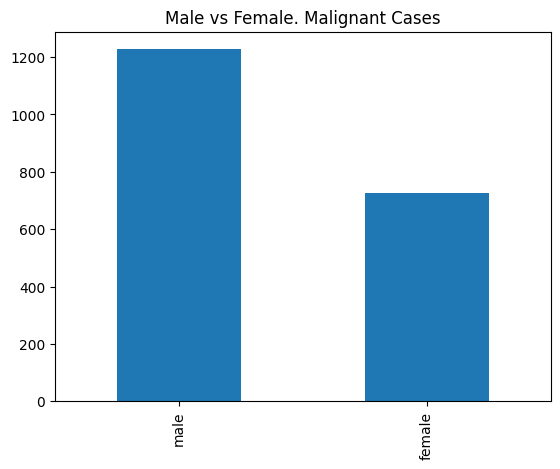

In [ ]:
skin_df[skin_df["Malignant"] == 1]["sex"].value_counts().plot(kind="bar", title="Male vs Female. Malignant Cases")

#### **OBSERVATIONS:** Most malignant cases occur in the male gender.

## FEATURE ENGINEERING

In [ ]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [ ]:
#Organizing dataset - input and output
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [ ]:
#Traing and testing sampling
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20)

In [ ]:
#Normalization - the x_train, x_test by substracting from theor mean values and then dividing by thier standard deviation.
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

#Splitting training into Train and Validate sets
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1)

# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

## TRAINING CNN ALGORITHM AS BASELINE ALGORITHM

In [ ]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(BatchNormalization())

model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

##############################
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
##############################
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))
model.summary()

In [ ]:
# Define the optimizer
#optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
optimizer = SGD(lr=0.0001, momentum=0.15, nesterov=False)
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
# data augmentation 
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10) 

In [ ]:
datagen.fit(x_train)

In [ ]:
## Fit the model
epochs = 25
batch_size = 32
history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate))

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

In [ ]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

#Show Classification report
target_names = ['class 0', 'class 1', 'class 2','class 3', 'class 4', 
                'class 5', 'class 6']
print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(Y_true, Y_pred_classes, target_names = target_names)))

In [ ]:
print(history.history.keys())

In [ ]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot training and validation accuracy per epoch
ax1.plot(epochs, acc, label = "training")
ax1.plot(epochs, val_acc, label = "validation")
ax1.legend(loc="upper left")
ax1.set_title('Training and validation accuracy')

# Plot training and validation loss per epoch
ax2.plot(epochs, loss, label = "training")
ax2.plot(epochs, val_loss, label = "validation")
ax2.legend(loc="upper right")
ax2.set_title('Training and validation loss')

# Display the plot
plt.show()

## TRAINING INCEPTIONV3 ALGORITHM

In [ ]:
input_shape = (75, 100, 3)

num_labels = 7

base_model = InceptionV3(include_top = False, input_shape = input_shape,pooling = 'avg', 
                         weights = 'imagenet')
model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)))
model.add(Dropout(0.5))
model.add(Dense(num_labels, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02)))

for layer in base_model.layers:
    layer.trainable = True

model.summary()

In [ ]:
#optimizer = Adam (lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
optimizer = SGD(lr=0.0001, momentum=0.15, nesterov=False)
model.compile(optimizer = optimizer , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
print(y_train.shape)
print(y_validate.shape)


In [ ]:
y_train = np.argmax(y_train, axis = 1)
y_validate = np.argmax(y_validate, axis = 1)

In [ ]:
epochs = 100 
batch_size = 32
history = model.fit(datagen.flow(x_train, y_train, batch_size = batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

In [ ]:
y_test = np.argmax(y_test, axis = 1)

loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

26/26 [==============================] - 0s 16ms/step - loss: 0.6755 - accuracy: 0.8117
Validation: accuracy = 0.811721  ;  loss_v = 0.675531
Test: accuracy = 0.817274  ;  loss = 0.630807


In [ ]:
#Show Classification report
target_names = ['class 0', 'class 1', 'class 2','class 3', 'class 4', 
                'class 5', 'class 6']
print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(Y_true, Y_pred_classes, target_names = target_names)))

Classification report for classifier <keras.engine.sequential.Sequential object at 0x7f88addb6d40>:
              precision    recall  f1-score   support

     class 0       1.00      0.04      0.08        23
     class 1       0.42      0.68      0.52        44
     class 2       0.56      0.62      0.59        99
     class 3       0.00      0.00      0.00        17
     class 4       0.88      0.94      0.91       511
     class 5       0.00      0.00      0.00        12
     class 6       0.65      0.51      0.57        96

    accuracy                           0.77       802
   macro avg       0.50      0.40      0.38       802
weighted avg       0.76      0.77      0.75       802




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


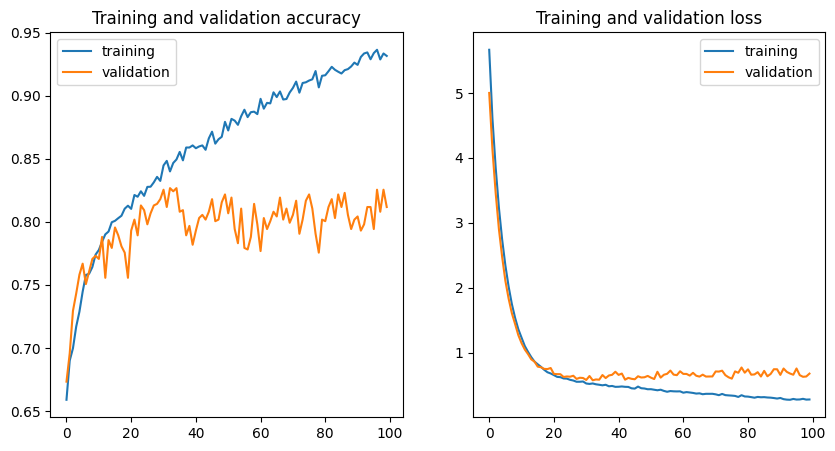

In [ ]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot training and validation accuracy per epoch
ax1.plot(epochs, acc, label = "training")
ax1.plot(epochs, val_acc, label = "validation")
ax1.legend(loc="upper left")
ax1.set_title('Training and validation accuracy')

# Plot training and validation loss per epoch
ax2.plot(epochs, loss, label = "training")
ax2.plot(epochs, val_loss, label = "validation")
ax2.legend(loc="upper right")
ax2.set_title('Training and validation loss')

# Display the plot
plt.show()

## TRAINING THE XCEPTION ALGORITHM

In [ ]:
input_shape = (75, 100, 3)

num_labels = 7

base_model = Xception(include_top = False, input_shape = input_shape,pooling = 'avg', 
                         weights = 'imagenet')
model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)))
model.add(Dropout(0.5))
model.add(Dense(num_labels, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02)))

for layer in base_model.layers:
    layer.trainable = True

model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout_7 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 7)                 903       
                                                                 
Total params: 21,124,655
Trainable params: 21,070,127
Non-trainable params: 54,528
______________________________________

In [ ]:
optimizer = SGD(lr=0.0001, momentum=0.15, nesterov=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [ ]:
#Traing and testing sampling
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20)
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

#Splitting training into Train and Validate sets
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1)

# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [ ]:
epochs =  50
batch_size = 32
history = model.fit(datagen.flow(x_train, y_train, batch_size = batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,
                    validation_steps=(x_validate.shape[0] // batch_size),
                    callbacks=[learning_rate_reduction])

Epoch 1/50
225/225 [==============================] - 43s 123ms/step - loss: 5.6835 - acc: 0.6510 - val_loss: 5.1962 - val_acc: 0.6372 - lr: 0.0100
Epoch 2/50
225/225 [==============================] - 23s 102ms/step - loss: 4.6318 - acc: 0.6733 - val_loss: 4.2718 - val_acc: 0.6372 - lr: 0.0100
Epoch 3/50
225/225 [==============================] - 23s 103ms/step - loss: 3.8909 - acc: 0.6747 - val_loss: 3.6064 - val_acc: 0.6372 - lr: 0.0100
Epoch 4/50
225/225 [==============================] - 23s 103ms/step - loss: 3.2926 - acc: 0.6793 - val_loss: 3.0738 - val_acc: 0.6434 - lr: 0.0100
Epoch 5/50
225/225 [==============================] - 24s 105ms/step - loss: 2.8211 - acc: 0.6895 - val_loss: 2.6358 - val_acc: 0.6596 - lr: 0.0100
Epoch 6/50
225/225 [==============================] - 23s 103ms/step - loss: 2.4319 - acc: 0.6970 - val_loss: 2.2888 - val_acc: 0.6621 - lr: 0.0100
Epoch 7/50
225/225 [==============================] - 24s 105ms/step - loss: 2.1121 - acc: 0.7016 - val_loss: 2.

In [ ]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

26/26 [==============================] - 2s 36ms/step
Classification report for classifier <keras.engine.sequential.Sequential object at 0x7f88addb6d40>:
              precision    recall  f1-score   support

     class 0       1.00      0.04      0.08        23
     class 1       0.42      0.68      0.52        44
     class 2       0.56      0.62      0.59        99
     class 3       0.00      0.00      0.00        17
     class 4       0.88      0.94      0.91       511
     class 5       0.00      0.00      0.00        12
     class 6       0.65      0.51      0.57        96

    accuracy                           0.77       802
   macro avg       0.50      0.40      0.38       802
weighted avg       0.76      0.77      0.75       802




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


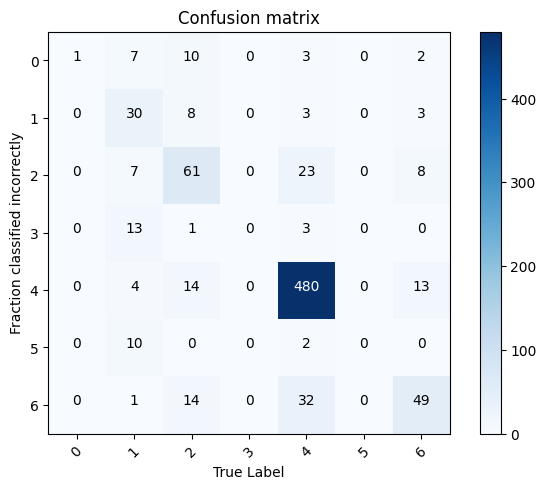

In [ ]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

#Show Classification report
target_names = ['class 0', 'class 1', 'class 2','class 3', 'class 4', 
                'class 5', 'class 6']
print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(Y_true, Y_pred_classes, target_names = target_names)))

In [ ]:
model.save('Xception.h5')

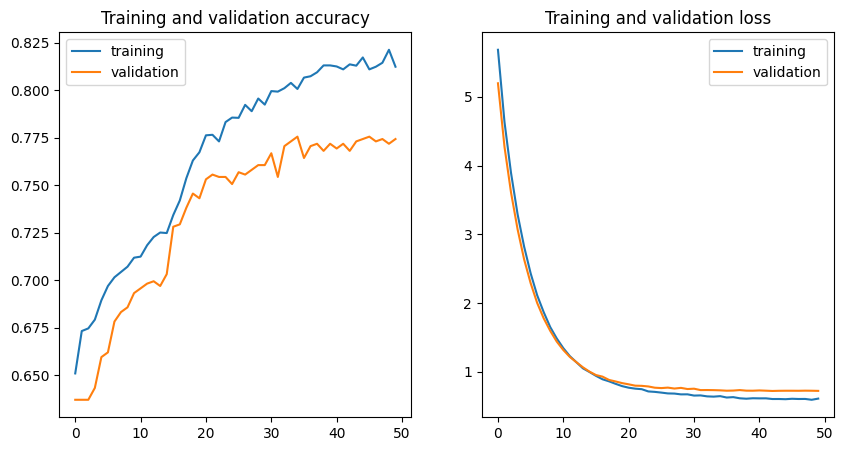

In [ ]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot training and validation accuracy per epoch
ax1.plot(epochs, acc, label = "training")
ax1.plot(epochs, val_acc, label = "validation")
ax1.legend(loc="upper left")
ax1.set_title('Training and validation accuracy')

# Plot training and validation loss per epoch
ax2.plot(epochs, loss, label = "training")
ax2.plot(epochs, val_loss, label = "validation")
ax2.legend(loc="upper right")
ax2.set_title('Training and validation loss')

# Display the plot
plt.show()

In [ ]:
np.save('x_train.npy', x_train)
np.save('y_train.npy', y_train)
np.save('x_validate.npy', x_validate)
np.save('y_validate.npy', x_validate)
np.save('x_test.npy', x_test)
np.save('y_test.npy', x_test)